# Bonus 2: Parallel Computing

### Name: [Gopi Miyani]


## 0. You will do the following:

1. Read the lecture note and the corresponding research papers.
(https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)


2. Implement federated averaging (easier) and/or decentralized optimization (harder). 2 bonus points for each. If you do both, submit them as two separate IPYNB files.


3. Data: use the data and template of Bonus 1.


4. Requirement for federated averaging:

Use 4 worker nodes.
Use GD and SGD (with batch size b=1).
Set the number of local iterations to q=1 and 8.
Plot (training) objective function against epochs. Note that one epoch means every sample is visited exactly once.
Note also that there are 4 lines in your plot. (GD with q=1, GD with q=8, SGD with q=1, SGD with q=8.)

5. Requirement for decentralized optimization:

Use 7 worker nodes; the connection must be the same as the figure in the lecture note.
Use GD.
Try weighted averaging (give a worker's own parameter a higher weight than its neighbors' parameters) and simple averaging (everyone has the same weight).
Plot (training) objective function against epochs. 
Note that there are at least 2 lines in your plot. (Corresponding to the weighting schemes.)
 

 



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [55]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [56]:
# partition the data to training and test sets
n = x.shape[0]
n_train = int(numpy.ceil(n * 0.8))
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (615, 8)
Shape of x_test: (153, 8)
Shape of y_train: (615, 1)
Shape of y_test: (153, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [57]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.06292817  0.01063182 -0.00699233 -0.06477095 -0.03569728  0.05473539
   0.12394643  0.17639928]]
test std = 
[[1.04738308 0.93685409 1.12869021 1.09330051 0.95301273 1.17454921
  0.98710941 1.1021825 ]]


## 1.4. Add a dimension of all ones

In [58]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (615, 9)
Shape of x_test: (153, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

## 2.1. Worker Node

In [59]:
class Worker:
    def __init__(self , x, y): 
        self.x = x # s—by—d local feature matrix 
        self.y = y # s—by-1 local label matrix 
        self.s = x. shape [0] # number of local samples 
        self.d = x. shape [1] # number of features 
        self.w = numpy. zeros ((d, 1)) # d—by-1 model parameter vector 

    # Set the model parameters to the latest 
    def set_param(self ,w): 
        self.w = w 

    # Compute the local loss 
    def loss(self): 
        yx = numpy.multiply(self.y, self.x) # s—by—d matrix 
        yxw = numpy.dot(yx, self.w) # s—by-1 matrix 
        vecl = numpy.exp(-(yxw)) # s—by-1 matrix 
        vec2 = numpy.log (1 + vecl) # s—by-1 matrix 
        return numpy.sum(vec2) # loss function 

    # Compute the local gradient 
    def gradient(self,q): 
        yx = numpy.multiply (self.y, self.x) # s—by—d matrix 
        yxw = numpy.dot (yx, self.w) # s—by-1 matrix 
        vecl = numpy.exp(yxw) # s—by-1 matrix 
        vec2 = numpy.divide(yx, 1+vecl) # s—by—d matrix 
        g = -numpy.sum(vec2,axis=0).reshape(self.d, 1) # d—by-1 matrix return g 
        return g

## 2.2. Server Node

In [60]:
class Server : 
    def __init__ (self , m, n, d): 
        self.m = m # number of worker nodes 
        self.n = n # number of training samples 
        self.d = d # number of features 
        self.w = numpy.zeros ((d, 1)) # # d—by-1 model parameter vector 
        self.g = numpy.zeros ((d, 1)) # d—by-1 gradient 
        self.v = numpy.zeros ((d, 1)) # d—by —1 momentum 
        self. loss = 0 # loss function value 
        self. obj = 0 # objective function value 
        
    def broadcast ( self ) : 
        return self.w 

# Sum the gradients and loss functions evaluated by the workers 
# Args: 
    # grads : a list of d—by-1 vectors
    # losses : a list of scalars 
    
    def aggregate (self , grads , losses ) : 
        self.g = numpy.zeros (( self.d, 1)) 
        self.loss = 0 
        for k in range( self.m) : 
            #print(self.g)
            #print("----")
            #print(grads[k])
            self.g += grads[k] 
            self.loss += losses[k] 
            
# Compute the gradient (from the loss and regularization ) 
    def gradient ( self , lam) : 
        self.g = self.g / self.n + lam * self.w 
        
# Compute the objective function (sum of loss and regularization ) 
    def objective ( self , lam) : 
        reg = lam / 2 * numpy.sum( self.w * self.w) 
        self.obj = self.loss / self.n + reg 
        return self.obj 
    
# Update the model parameters using accelerated gradient descent 
# Args: 
    # alpha: learning rate (step size ) 
    # beta : momentum parameter 
    def agd( self , alpha , beta) : 
        self.v *= beta 
        self.v += self.g 
        self.w -= alpha * self.v 


## 2.3. Initialization 

In [61]:
import math 
# Create a server and m worker nodes 
def create_server_workers (m, x, y) : 
    n, d = x. shape 
    s = math. floor (n / m) 
    server = Server (m, n, d) 
    workers = [] 
    for i in range (m) : 
        indices = list (range(i*s , (i+1)*s)) 
        worker = Worker(x [ indices , :] , y [ indices , :]) 
        workers . append ( worker ) 
    return server , workers 

 
m = 4 # number of worker nodes 
server , workers = create_server_workers (m, x_train , y_train ) 


In [62]:
lam = 1E-6 # regularization parameter 
alpha = 1E-1 # learning rate 
beta = 0.9 # momentum parameter 
max_epoch = 10 # number of epochs 
for t in range (max_epoch) : 
    # step 1: broadcast 
    w = server.broadcast() 
    for i in range (m) : 
        workers[ i ].set_param (w) 

    # step 2: workers' local computations 
    grads = [] 
    losses = [] 
    q=1
    for i in range (m) : 
        g = workers[i].gradient(q)
        grads.append(g) 
        l = workers[i].loss() 
        losses.append( l ) 
    #print("grad" + str(grads))
    # step 3: aggregate the workers ' outputs 
    server.aggregate( grads , losses) 

    # step 4: server update the model parameters 
    server.gradient(lam) # compute gradient 
    obj = server.objective (lam) # compute compute objective function 
    print ('Objective function value = ' + str (obj) ) 
    server.agd (alpha , beta) # updates the model parameters 


Objective function value = 0.6897659748011163
Objective function value = 0.6775401123908128
Objective function value = 0.6561613161435644
Objective function value = 0.6295661257206712
Objective function value = 0.6016290311027173
Objective function value = 0.5754074408484188
Objective function value = 0.5527686087790677
Objective function value = 0.5344392387890108
Objective function value = 0.520318129596414
Objective function value = 0.5098424275394172


In [63]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [64]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [65]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [66]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [67]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5929443919757862
Objective value at t=2 is 0.5516037061665903
Objective value at t=3 is 0.5293145114381133
Objective value at t=4 is 0.5154463440683746
Objective value at t=5 is 0.5061065052355512
Objective value at t=6 is 0.49950067219294686
Objective value at t=7 is 0.49467040558974085
Objective value at t=8 is 0.4910513542048101
Objective value at t=9 is 0.48828823173432295
Objective value at t=10 is 0.4861463994615091
Objective value at t=11 is 0.4844652386794547
Objective value at t=12 is 0.48313167133135065
Objective value at t=13 is 0.4820642537341396
Objective value at t=14 is 0.4812031978683424
Objective value at t=15 is 0.4805038922909274
Objective value at t=16 is 0.4799325756508955
Objective value at t=17 is 0.4794633788304112
Objective value at t=18 is 0.4790762614294054
Objective value at t=19 is 0.4787555464100609
Objective value at t=20 is 0.4784888629534222
Objective value at t=21 is 0.47826637290

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [68]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    d = xi.shape[0]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [69]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [70]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.52809130798053
Objective value at epoch t=1 is 0.5321133061485736
Objective value at epoch t=2 is 0.5143560880311044
Objective value at epoch t=3 is 0.5149895098636783
Objective value at epoch t=4 is 0.5114225054744105
Objective value at epoch t=5 is 0.49871481189998923
Objective value at epoch t=6 is 0.5115396747466047
Objective value at epoch t=7 is 0.5072164939740491
Objective value at epoch t=8 is 0.4953700925997171
Objective value at epoch t=9 is 0.49457738321473066
Objective value at epoch t=10 is 0.49579711341449806
Objective value at epoch t=11 is 0.4964601584689119
Objective value at epoch t=12 is 0.49266703867044725
Objective value at epoch t=13 is 0.49193309158790705
Objective value at epoch t=14 is 0.4931084540715684
Objective value at epoch t=15 is 0.489913384373484
Objective value at epoch t=16 is 0.4873226143615006
Objective value at epoch t=17 is 0.48699195098891107
Objective value at epoch t=18 is 0.4831165394607236
Objective value at 

# 4. Compare GD with SGD

Plot objective function values against epochs.

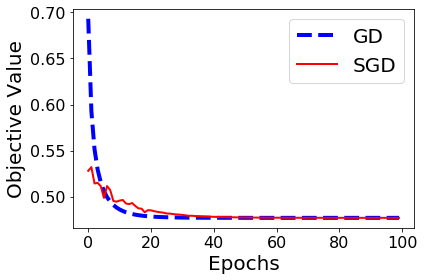

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [72]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [73]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.21951219512195122


In [74]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.22875816993464052
